In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [44]:
#Convert MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Color Channels)
transform = transforms.ToTensor()

In [45]:
#Train Data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

In [6]:
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [46]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
pwd

'/content'

In [10]:
ls

data/  sample_data/


In [11]:
#create  a small batch size of images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [12]:
#define cnn model
# describe convolutional layer
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [13]:
#grab one mnist records
for i, (X_train, y_train) in enumerate(train_data):
    break

In [14]:
X_train

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [15]:
X_train.shape

torch.Size([1, 28, 28])

In [16]:
x = X_train.view(1, 1, 28, 28)

In [17]:
#perform first convolution
x = F.relu(conv1(x))

In [18]:
x.shape

torch.Size([1, 6, 26, 26])

In [19]:
x = F.max_pool2d(x, 2, 2) #kernel of 2 and stride of 23

In [20]:
x.shape

torch.Size([1, 6, 13, 13])

In [21]:
#2nd convolution
x = F.relu(conv2(x))

In [22]:
x.shape #didn't set padding, lose 2 pixels around the

torch.Size([1, 16, 11, 11])

In [23]:
x = F.max_pool2d(x, 2, 2)

In [24]:
x.shape

torch.Size([1, 16, 5, 5])

In [27]:
#Model Class
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    #fully connected
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)

    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    #Review to flatten
    X = X.view(-1, 5*5*16)   #negative to one so that we can vary thr batch size

    #fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [28]:
#create an instance for our model
torch.manual_seed(41)
model = ConvolutionalNeuralNetwork()
model

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [29]:
#Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        #smaller learning rate, more time to train

In [37]:
import time
start_time = time.time()

#Create variables to rack things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#for loop for epochs
for i in range(epochs):
  train_corr = 0
  test_corr = 0

  #Train
  for batch, (X_train, y_train) in enumerate(train_loader):
    batch += 1 #start our batches at 1
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)

    predicted = torch.max(y_pred.data, 1)[1]            #add the no to correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum()            #how many we got correct from this batch
    train_corr += batch_corr


    #update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print out some results
    if batch % 200 == 0:
      print(f'Epoch: {i} Batch: {batch} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(train_corr)


  #Test
  with torch.no_grad():   #No gradient so we don't update our weights and biases with test
    for batch, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]            #adding up correct predictions
      test_corr += (predicted == y_test).sum()


    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)





current_time = time.time()
total_time = current_time - start_time
print(f'Training Took: {total_time/60} minutes!')

Epoch: 0 Batch: 200 Loss: 0.5736042261123657
Epoch: 0 Batch: 400 Loss: 0.2891865372657776
Epoch: 0 Batch: 600 Loss: 0.1799113005399704
Epoch: 0 Batch: 800 Loss: 0.29122111201286316
Epoch: 0 Batch: 1000 Loss: 0.050317902117967606
Epoch: 0 Batch: 1200 Loss: 0.2360541820526123
Epoch: 0 Batch: 1400 Loss: 0.6602636575698853
Epoch: 0 Batch: 1600 Loss: 0.06507696211338043
Epoch: 0 Batch: 1800 Loss: 0.016516011208295822
Epoch: 0 Batch: 2000 Loss: 0.01824507862329483
Epoch: 0 Batch: 2200 Loss: 0.010132698342204094
Epoch: 0 Batch: 2400 Loss: 0.11891243606805801
Epoch: 0 Batch: 2600 Loss: 0.12045158445835114
Epoch: 0 Batch: 2800 Loss: 0.2515462040901184
Epoch: 0 Batch: 3000 Loss: 0.09155439585447311
Epoch: 0 Batch: 3200 Loss: 0.35212475061416626
Epoch: 0 Batch: 3400 Loss: 0.005924412049353123
Epoch: 0 Batch: 3600 Loss: 0.01931670866906643
Epoch: 0 Batch: 3800 Loss: 0.015211723744869232
Epoch: 0 Batch: 4000 Loss: 0.003487108740955591
Epoch: 0 Batch: 4200 Loss: 0.029946219176054
Epoch: 0 Batch: 440

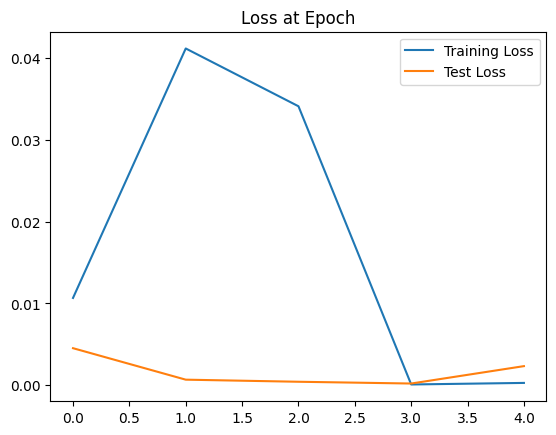

In [50]:
train_losses = [t1.item() if hasattr(t1,'item') else t1 for t1 in train_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss at Epoch')
plt.legend()

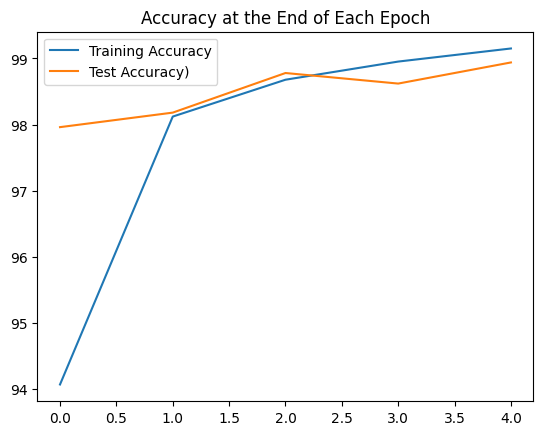

In [40]:
#accuracy
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Test Accuracy)")
plt.title("Accuracy at the End of Each Epoch")
plt.legend()

In [51]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [52]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()

In [54]:
correct.item()/len(test_data)

0.9894

In [57]:
from sklearn.metrics import accuracy_score

In [58]:
print(accuracy_score)

<function accuracy_score at 0x7ba1bcddc4c0>
